# Computational imaging of aerosol reactivity outcomes

In [1]:
# Apply environment variables from .env file
from os import environ

for line in open('.env', 'r'):
    line = line.strip()
    if not line or line.startswith('#') or '=' not in line:
        continue
    var, val = line.split('=', 1)
    environ[var] = val

In [4]:
import gzip
import pickle
from pathlib import Path

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
from ipywidgets import Button, Layout, interact
from scipy.stats import multivariate_normal, norm
from skimage.measure import perimeter
from sklearn.mixture import GaussianMixture
from tqdm.auto import tqdm
from transformers import pipeline

N_CLUSTERS = 3
DATA_HOME = Path(environ['DATA_HOME'])

sns.set_theme(style="ticks", context="notebook", font_scale=1.2, font="Arial")
matplotlib.rcParams["svg.fonttype"] = "none"

In [5]:
sample_image_files = [*(DATA_HOME / 'ZCY-014' / 'test').glob('*.jpg'),
                      *(DATA_HOME / 'ZCY-010').glob('*together*.jpg'),
                      *(DATA_HOME / 'ZCY-009').glob('ZCY*.jpg'),
                      ]
sample_image_files = {p.stem: p for p in sample_image_files}
list(sample_image_files)

['ZCY-014c 2023-08-29_18-21-58',
 'ZCY-014c 2023-08-29_18-08-39',
 'ZCY-014c 2023-08-29_18-26-57',
 'ZCY-014c 2023-08-29_18-10-31',
 'ZCY-014c 2023-08-29_18-08-18',
 'ZCY-010 together 2023-08-22_15-50-59',
 'ZCY-010 together 2023-08-22_15-51-28',
 'ZCY-010 together 2023-08-22_15-51-54',
 'ZCY-010 together 2023-08-22_15-53-09',
 'ZCY-010 together 2023-08-22_15-52-26',
 'ZCY-009 2023-08-21_16-59-33',
 'ZCY-009 2023-08-21_17-04-24',
 'ZCY-009 2023-08-21_16-58-26',
 'ZCY-009-2 2023-08-21_17-52-13',
 'ZCY-009 2023-08-21_17-07-38',
 'ZCY-009-1 2023-08-21_17-27-29',
 'ZCY-009 2023-08-21_17-05-29',
 'ZCY-009-1 2023-08-21_17-25-54',
 'ZCY-009-2 2023-08-21_17-54-42',
 'ZCY-009-2 2023-08-21_17-53-40',
 'ZCY-009 2023-08-21_16-57-29',
 'ZCY-009-1 2023-08-21_17-23-52',
 'ZCY-009-1 2023-08-21_17-24-13',
 'ZCY-009-1 2023-08-21_17-26-13',
 'ZCY-009-1 2023-08-21_17-26-36',
 'ZCY-009-1 2023-08-21_17-24-36']

In [242]:
#read image file
imgs_RGB = {id: PIL.Image.open(path) for id, path in tqdm(sample_image_files.items())}
# scaled down to 1/4 size
imgs_small_RGB = {id: img.resize((img.width // 4, img.height // 4)) for id, img in tqdm(imgs_RGB.items())}
imgs_HSV = {id: img.convert('HSV') for id, img in tqdm(imgs_RGB.items())}
imgs_small_HSV = {id: img.resize((img.width // 4, img.height // 4)) for id, img in tqdm(imgs_HSV.items())}
imgs_LAB = {id: img.convert('LAB') for id, img in tqdm(imgs_RGB.items())}
imgs_small_LAB = {id: img.resize((img.width // 4, img.height // 4)) for id, img in tqdm(imgs_LAB.items())}

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

## Interactive dashboard to see images in different colour spaces

In [153]:
@interact(id=list(imgs_small_RGB.keys()), space=['RGB', 'HSV', 'LAB'])
def show_image(id, space):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    if space == 'RGB':
        img = imgs_small_RGB[id]
    elif space == 'HSV':
        img = imgs_small_HSV[id]
    elif space == 'LAB':
        img = imgs_small_LAB[id]
    for i, ax in enumerate(ax):
        ax.imshow(img[:, :, i])
        # colorbar
        # make sure colorbar is not too tall
        plt.colorbar(ax.images[0], ax=ax, orientation='horizontal')
        ax.set_title(f'{space} channel {i}')
    fig.tight_layout()

interactive(children=(Dropdown(description='id', options=('ZCY-014c 2023-08-29_18-21-58', 'ZCY-014c 2023-08-29…

In [154]:
mask_generator = pipeline(
    task="mask-generation",
    model="facebook/sam-vit-base",
    device="cuda",
    points_per_crop=64,
    pred_iou_thresh=0.2,
    stability_score_thresh=0.2,
    crops_nms_thresh=0.1,
    points_per_batch=128,
)

Device set to use cuda


In [243]:
mask_file = Path("out/masks.pkl.gz")
mask_file.parent.mkdir(parents=True, exist_ok=True)

if mask_file.exists():
    with gzip.open(mask_file, "rb") as f:
        masks = {
            id: mask for id, mask in pickle.load(f).items() if id in imgs_small_RGB
        }
else:
    masks = {}

new_masks = {
    id: np.array(mask_generator(img)["masks"])
    for id, img in tqdm(imgs_small_RGB.items())
    if id not in masks
}
# Save masks to pickle file
if new_masks:
    masks.update(new_masks)
    if mask_file.exists():
        # make a backup of current mask_file with a timestamp
        backup_file = mask_file.with_name(
            f'{mask_file.stem}_{pd.Timestamp.now().strftime("%Y%m%d%H%M%S")}{mask_file.suffix}'
        )
        mask_file.rename(backup_file)
    with gzip.open(mask_file, "wb") as f:
        pickle.dump(masks, f)
{id: len(img_masks) for id, img_masks in masks.items()}

  0%|          | 0/26 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


{'ZCY-014c 2023-08-29_18-21-58': 1613,
 'ZCY-014c 2023-08-29_18-08-39': 1684,
 'ZCY-014c 2023-08-29_18-26-57': 1494,
 'ZCY-014c 2023-08-29_18-10-31': 1674,
 'ZCY-014c 2023-08-29_18-08-18': 1710,
 'ZCY-010 together 2023-08-22_15-50-59': 958,
 'ZCY-010 together 2023-08-22_15-51-28': 896,
 'ZCY-010 together 2023-08-22_15-51-54': 936,
 'ZCY-010 together 2023-08-22_15-53-09': 828,
 'ZCY-010 together 2023-08-22_15-52-26': 893,
 'ZCY-009 2023-08-21_16-59-33': 186,
 'ZCY-009 2023-08-21_17-04-24': 319,
 'ZCY-009 2023-08-21_16-58-26': 107,
 'ZCY-009-2 2023-08-21_17-52-13': 850,
 'ZCY-009 2023-08-21_17-07-38': 223,
 'ZCY-009-1 2023-08-21_17-27-29': 947,
 'ZCY-009 2023-08-21_17-05-29': 141,
 'ZCY-009-1 2023-08-21_17-25-54': 1029,
 'ZCY-009-2 2023-08-21_17-54-42': 999,
 'ZCY-009-2 2023-08-21_17-53-40': 1014,
 'ZCY-009 2023-08-21_16-57-29': 110,
 'ZCY-009-1 2023-08-21_17-23-52': 852,
 'ZCY-009-1 2023-08-21_17-24-13': 801,
 'ZCY-009-1 2023-08-21_17-26-13': 958,
 'ZCY-009-1 2023-08-21_17-26-36': 919,


In [245]:
# convert to numpy arrays
for collection in [imgs_RGB, imgs_small_RGB, imgs_HSV, imgs_small_HSV, imgs_LAB, imgs_small_LAB]:
    for id, img in collection.items():
        collection[id] = np.array(img)

In [246]:
MAX_MASK_AREA = 1500
MIN_MASK_AREA = 50

masks_filtered = {
    id: np.array(
        [mask for mask in img_masks if MIN_MASK_AREA < mask.sum() < MAX_MASK_AREA]
    )
    for id, img_masks in tqdm(masks.items())
}
{id: len(img_masks) for id, img_masks in masks_filtered.items()}

  0%|          | 0/26 [00:00<?, ?it/s]

{'ZCY-014c 2023-08-29_18-21-58': 1573,
 'ZCY-014c 2023-08-29_18-08-39': 1673,
 'ZCY-014c 2023-08-29_18-26-57': 1427,
 'ZCY-014c 2023-08-29_18-10-31': 1643,
 'ZCY-014c 2023-08-29_18-08-18': 1699,
 'ZCY-010 together 2023-08-22_15-50-59': 701,
 'ZCY-010 together 2023-08-22_15-51-28': 620,
 'ZCY-010 together 2023-08-22_15-51-54': 593,
 'ZCY-010 together 2023-08-22_15-53-09': 553,
 'ZCY-010 together 2023-08-22_15-52-26': 523,
 'ZCY-009 2023-08-21_16-59-33': 25,
 'ZCY-009 2023-08-21_17-04-24': 39,
 'ZCY-009 2023-08-21_16-58-26': 37,
 'ZCY-009-2 2023-08-21_17-52-13': 628,
 'ZCY-009 2023-08-21_17-07-38': 43,
 'ZCY-009-1 2023-08-21_17-27-29': 707,
 'ZCY-009 2023-08-21_17-05-29': 29,
 'ZCY-009-1 2023-08-21_17-25-54': 862,
 'ZCY-009-2 2023-08-21_17-54-42': 564,
 'ZCY-009-2 2023-08-21_17-53-40': 654,
 'ZCY-009 2023-08-21_16-57-29': 67,
 'ZCY-009-1 2023-08-21_17-23-52': 719,
 'ZCY-009-1 2023-08-21_17-24-13': 673,
 'ZCY-009-1 2023-08-21_17-26-13': 758,
 'ZCY-009-1 2023-08-21_17-26-36': 765,
 'ZCY-00

In [249]:
MIN_CIRCULARITY = 0.8

def get_circularity(mask):
    area = mask.sum()
    p = perimeter(mask)
    if p == 0:
        return 0
    return 4 * np.pi * area / (p * p)

masks_filtered = {
    id: np.array([
        mask for mask in img_masks 
        if (MIN_MASK_AREA < mask.sum() < MAX_MASK_AREA) and 
           get_circularity(mask) > MIN_CIRCULARITY
    ])
    for id, img_masks in tqdm(masks_filtered.items())
}
{id: len(img_masks) for id, img_masks in masks_filtered.items()}


  0%|          | 0/26 [00:00<?, ?it/s]

{'ZCY-014c 2023-08-29_18-21-58': 1462,
 'ZCY-014c 2023-08-29_18-08-39': 1531,
 'ZCY-014c 2023-08-29_18-26-57': 1302,
 'ZCY-014c 2023-08-29_18-10-31': 1494,
 'ZCY-014c 2023-08-29_18-08-18': 1564,
 'ZCY-010 together 2023-08-22_15-50-59': 498,
 'ZCY-010 together 2023-08-22_15-51-28': 414,
 'ZCY-010 together 2023-08-22_15-51-54': 413,
 'ZCY-010 together 2023-08-22_15-53-09': 386,
 'ZCY-010 together 2023-08-22_15-52-26': 367,
 'ZCY-009 2023-08-21_16-59-33': 11,
 'ZCY-009 2023-08-21_17-04-24': 15,
 'ZCY-009 2023-08-21_16-58-26': 27,
 'ZCY-009-2 2023-08-21_17-52-13': 381,
 'ZCY-009 2023-08-21_17-07-38': 19,
 'ZCY-009-1 2023-08-21_17-27-29': 475,
 'ZCY-009 2023-08-21_17-05-29': 11,
 'ZCY-009-1 2023-08-21_17-25-54': 586,
 'ZCY-009-2 2023-08-21_17-54-42': 408,
 'ZCY-009-2 2023-08-21_17-53-40': 480,
 'ZCY-009 2023-08-21_16-57-29': 45,
 'ZCY-009-1 2023-08-21_17-23-52': 439,
 'ZCY-009-1 2023-08-21_17-24-13': 406,
 'ZCY-009-1 2023-08-21_17-26-13': 493,
 'ZCY-009-1 2023-08-21_17-26-36': 496,
 'ZCY-00

# Choosing representative colours for each droplet

In [162]:
def avg_region_color(img, masks):
    """
    Return the average color of the pixels in each mask.
    """
    mask_pixels = [img[m] for m in masks]
    region_pixels = np.array([m.mean(axis=0) for m in mask_pixels])
    return region_pixels / 255

In [163]:
def max_region_color(img, masks):
    """
    Return the color of the pixel with the largest norm in each mask.
    Meant for use with RGB images only.
    """
    mask_pixels = [img[m] for m in masks]
    representative_pixel = [np.linalg.norm(pixels, axis=-1).argmax() for pixels in mask_pixels]
    region_pixels = np.array([mask_pixels[i][representative_pixel[i]] for i in range(len(mask_pixels))])
    return region_pixels / 255

In [164]:
def max_value_region_color(img, masks):
    """
    Return the color of the pixel with the largest V (value) in each mask.
    Meant for use with HSV images only.
    """
    mask_pixels = [img[m] for m in masks]
    # find the pixel with the largest value in the third (V) channel
    representative_pixel = [pixels[..., 2].argmax() for pixels in mask_pixels]
    region_pixels = np.array([mask_pixels[i][representative_pixel[i]] for i in range(len(mask_pixels))])
    return region_pixels / 255

In [165]:
def max_sat_region_color(img, masks):
    """
    Return the color of the pixel with the largest S (saturation) in each mask.
    Meant for use with HSV images only.
    """
    mask_pixels = [img[m] for m in masks]
    representative_pixel = [pixels[..., 1].argmax() for pixels in mask_pixels]
    region_pixels = np.array([mask_pixels[i][representative_pixel[i]] for i in range(len(mask_pixels))])
    return region_pixels / 255

In [166]:
def max_SV_region_color(img, masks):
    """
    Return the color of the pixel with the largest product of S (saturation) and V (value) in each mask.
    Meant for use with HSV images only.
    """
    mask_pixels = [img[m] for m in masks]
    # indices of the middle 25% V pixels
    representative_pixels = [np.argsort(pixels[..., 2])[-(pixels.shape[0] // 4):] for pixels in mask_pixels]
    # index of max S among the top 50% V pixels
    representative_pixel = [pixels[:, 1][representative_pixels[i]].argmax() for i, pixels in enumerate(mask_pixels)]
    region_pixels = np.array([mask_pixels[i][representative_pixels[i][representative_pixel[i]]] for i in range(len(mask_pixels))])
    return region_pixels / 255

In [167]:
def max_SV_AB_color(img_hsv, img_lab, masks):
    """
    Return the color of the pixel with the largest product of S (saturation) and V (value) in each mask.
    Meant for use with HSV images only.
    """
    mask_pixels_hsv = [img_hsv[m] for m in masks]
    mask_pixels_lab = [img_lab[m] for m in masks]
    # indices of the middle 25% V pixels
    representative_pixels = [np.argsort(pixels[..., 2])[-(pixels.shape[0] // 4):] for pixels in mask_pixels_hsv]
    # index of max S among the top 50% V pixels
    representative_pixel = [pixels[representative_pixels[i]][:, 1].argmax() for i, pixels in enumerate(mask_pixels_hsv)]
    region_pixels = np.array([mask_pixels_lab[i][representative_pixels[i][representative_pixel[i]]] for i in range(len(mask_pixels_hsv))])
    return region_pixels / 255

In [168]:
def max_SV_RGB_color(img_hsv, img_rgb, masks):
    """
    Return the color of the pixel with the largest product of S (saturation) and V (value) in each mask.
    Meant for use with HSV images only.
    """
    mask_pixels_hsv = [img_hsv[m] for m in masks]
    mask_pixels_rgb = [img_rgb[m] for m in masks]
    # indices of the middle 25% V pixels
    representative_pixels = [np.argsort(pixels[..., 2])[-(pixels.shape[0] // 4):] for pixels in mask_pixels_hsv]
    # index of max S among the top 25% V pixels
    representative_pixel = [pixels[representative_pixels[i]][:, 1].argmax() for i, pixels in enumerate(mask_pixels_hsv)]
    region_pixels = np.array([mask_pixels_rgb[i][representative_pixels[i][representative_pixel[i]]] for i in range(len(mask_pixels_hsv))])
    return region_pixels / 255

In [169]:
def max_V_RGB_color(img_hsv, img_rgb, masks):
    """
    Return the RGB color of the pixel with the largest V (value) in each mask.
    """
    mask_pixels_hsv = [img_hsv[m] for m in masks]
    mask_pixels_rgb = [img_rgb[m] for m in masks]
    representative_pixel = [pixels[..., 2].argmax() for pixels in mask_pixels_hsv]
    region_pixels = np.array([mask_pixels_rgb[i][pixel] for i, pixel in enumerate(representative_pixel)])
    return region_pixels / 255

In [170]:
def max_SV_prod_AB_color(img_hsv, img_lab, masks):
    """
    Return the color of the pixel with the largest product of S (saturation) and V (value) in each mask.
    Meant for use with HSV images only.
    """
    mask_pixels_hsv = [img_hsv[m] for m in masks]
    mask_pixels_lab = [img_lab[m] for m in masks]

    representative_pixels = [np.prod(pixels[..., 1:], axis=-1).argmax() for pixels in mask_pixels_hsv]

    region_pixels = np.array([mask_pixels_lab[i][representative_pixels[i]] for i in range(len(mask_pixels_hsv))])
    return region_pixels / 255

In [171]:
def centre_region_color(img, masks):
    """
    Return the color of the pixel at the centre of each mask.
    """
    result = []
    for mask in masks:
        h, v = np.nonzero(mask)
        h, v = int(h.mean()), int(v.mean())
        result.append(img[h, v])
    return np.array(result) / 255

In [235]:
def add_scalebar(ax, length, text, color='black'):
    scalebar_length = length  # plot coordinate units
    scalebar_height = 10
    
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    scalebar_y = ylim[0] + (ylim[1] - ylim[0])*0.1
    scalebar_x = xlim[1] - (xlim[1] - xlim[0])*0.25
    
    rect = patches.Rectangle((scalebar_x, scalebar_y), 
                            scalebar_length, scalebar_height,
                           facecolor=color,
                           edgecolor='none',
                           transform=ax.transData)
    ax.add_patch(rect)
    ax.text(scalebar_x + scalebar_length/2,
            scalebar_y - scalebar_height*1.5,
            text, color=color, fontweight='bold',
            horizontalalignment='center',
            transform=ax.transData)

In [291]:
def hsv_to_rgb(hsv):
    hsv_uint8 = (hsv * 255).astype(np.uint8)[:, None, :]
    hsv_img = PIL.Image.fromarray(hsv_uint8, mode='HSV')
    rgb_img = hsv_img.convert('RGB')
    return np.array(rgb_img).astype(float)[:, 0, :] / 255


def lab_to_rgb(lab):
    lab_uint8 = (lab * 255).astype(np.uint8)[:, None, :]
    lab_img = PIL.Image.fromarray(lab_uint8, mode='LAB')
    rgb_img = lab_img.convert('RGB')
    return np.array(rgb_img).astype(float)[:, 0, :] / 255


def make_visualisation(colors, masks):
    result = np.zeros((masks[0].shape[0], masks[0].shape[1], 3))
    for mask, color in zip(masks, colors):
        result[mask] = color
    return result

methods = {
    'avg': lambda id: (avg_region_color(imgs_small_RGB[id], masks_filtered[id]), lambda colors: make_visualisation(colors, masks_filtered[id])),
    'max': lambda id: (max_region_color(imgs_small_RGB[id], masks_filtered[id]), lambda colors: make_visualisation(colors, masks_filtered[id])),
    'max_V': lambda id: (max_value_region_color(imgs_small_HSV[id], masks_filtered[id]), lambda colors: make_visualisation(hsv_to_rgb(colors), masks_filtered[id])),
    'max_S': lambda id: (max_sat_region_color(imgs_small_HSV[id], masks_filtered[id]), lambda colors: make_visualisation(hsv_to_rgb(colors), masks_filtered[id])),
    'max_SV': lambda id: (max_SV_region_color(imgs_small_HSV[id], masks_filtered[id]), lambda colors: make_visualisation(hsv_to_rgb(colors), masks_filtered[id])),
    'max_SV_AB': lambda id: (max_SV_AB_color(imgs_small_HSV[id], imgs_small_LAB[id], masks_filtered[id]), lambda colors: make_visualisation(lab_to_rgb(colors), masks_filtered[id])),
    'max_SV_RGB': lambda id: (max_SV_RGB_color(imgs_small_HSV[id], imgs_small_RGB[id], masks_filtered[id]), lambda colors: make_visualisation(colors, masks_filtered[id])),
    'max_V_RGB': lambda id: (max_V_RGB_color(imgs_small_HSV[id], imgs_small_RGB[id], masks_filtered[id]), lambda colors: make_visualisation(colors, masks_filtered[id])),
    'max_SV_prod_AB': lambda id: (max_SV_prod_AB_color(imgs_small_HSV[id], imgs_small_LAB[id], masks_filtered[id]), lambda colors: make_visualisation(lab_to_rgb(colors), masks_filtered[id])),
    'centre': lambda id: (centre_region_color(imgs_small_RGB[id], masks_filtered[id]), lambda colors: make_visualisation(colors, masks_filtered[id])),
}


@interact(id=list(imgs_small_RGB.keys()), method=list(methods.keys()), ticks=True)
def show_image(id, method, ticks):
    global chosen_id, chosen_method, colors
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
    ax[0].imshow(imgs_small_RGB[id])
    colors, visualisation = methods[method](id)
    ax[1].imshow(np.minimum(visualisation(colors), 1.0))
    if not ticks:
        for a in ax:
            a.axis('off')
    chosen_id = id
    chosen_method = method
    save_button = Button(description='Save', layout=Layout(width='100px'))
    save_button.on_click(lambda b: fig.savefig(f'out/{id}_{method}.svg', bbox_inches='tight', transparent=True))
    display(save_button)

    add_scalebar(ax[0], 200, '200 µm', color='black')
    add_scalebar(ax[1], 200, '200 µm', color='white')
    fig.tight_layout()

interactive(children=(Dropdown(description='id', options=('ZCY-014c 2023-08-29_18-21-58', 'ZCY-014c 2023-08-29…

In [297]:
@interact(id=list(imgs_small_RGB.keys()))
def size_histogram(id):
    fig, ax = plt.subplots(figsize=(6,5))
    area_pixels = masks_filtered[id].sum(axis=(1,2))
    # 1000 px x 1000 px = 1000,000 px^2 = 1 mm^2 = 1000,000 um^2
    area_um2 = area_pixels / 1.0
    diameter_um = 2 * np.sqrt(area_um2 / np.pi)
    sns.histplot(diameter_um, ax=ax)
    ax.set_xlabel('Diameter (um)')
    ax.set_ylabel('Count')
    save_button = Button(description='Save')
    save_button.on_click(lambda b: fig.savefig(f'out/diameter_distribution_{id}.svg', bbox_inches='tight', transparent=True))
    display(save_button)

interactive(children=(Dropdown(description='id', options=('ZCY-014c 2023-08-29_18-21-58', 'ZCY-014c 2023-08-29…

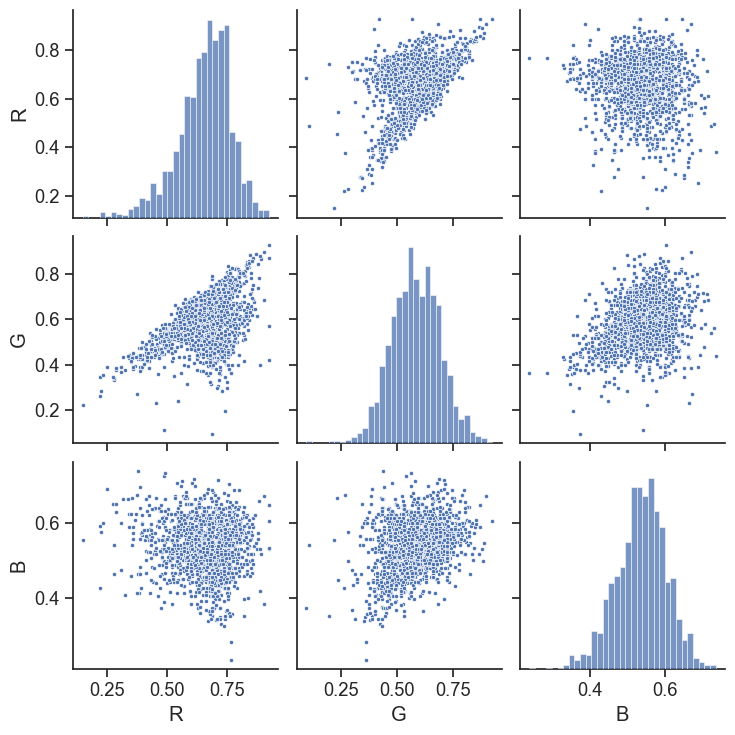

In [298]:
data = pd.DataFrame(colors, columns=['R', 'G', 'B'])
sns.pairplot(data, markers='.')
gm = GaussianMixture(n_components=4)
fit = gm.fit(data)
results = (fit.means_, fit.covariances_, fit.weights_, fit.predict_proba(data))

### Visualizing the Gaussian distributions

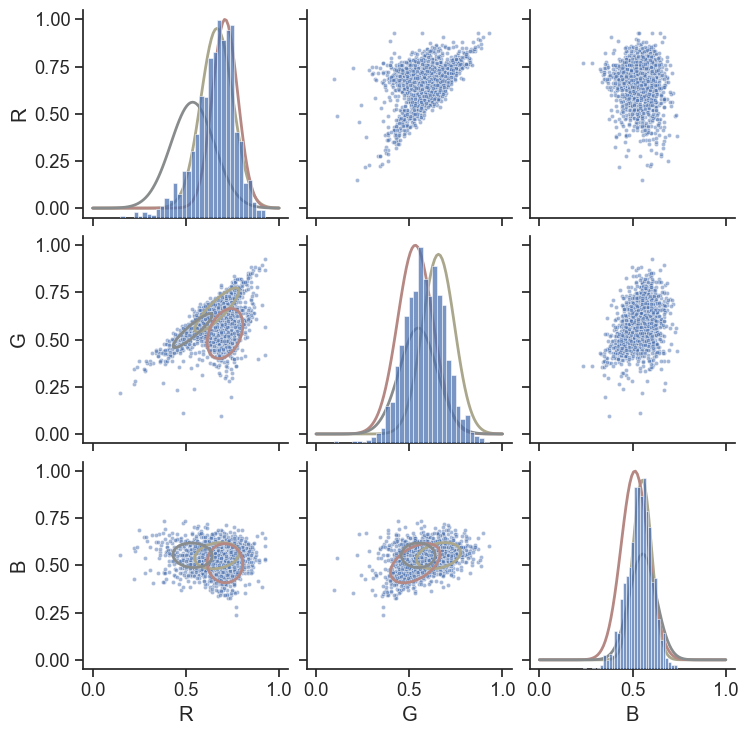

In [310]:
gm = GaussianMixture(n_components=N_CLUSTERS, covariance_type="full")
fit = gm.fit(colors)

mus, covs, weights = fit.means_, fit.covariances_, fit.weights_

axs = sns.pairplot(data, markers=".", plot_kws={"alpha": 0.5})

# Get the pairplot axes
axes = axs.axes

for i in range(N_CLUSTERS):
    cluster_color = mus[i]
    for j in range(3):
        # For diagonal plots, show marginal distribution
        marginal_var = covs[i, j, j]
        x = np.linspace(0.0, 1.0, 100)
        y = norm.pdf(x, mus[i, j], np.sqrt(marginal_var))
        axes[j, j].plot(
            x, y / y.max() * weights[i] / weights.max(), color=cluster_color, lw=2
        )

        for k in range(j+1, 3):
                
            # For off-diagonal plots, show PDF contours using full covariance
            cov_2d = covs[i][[j,k]][:,[j,k]]
            mu_2d = mus[i][[j,k]]
            
            # Create grid of points
            x, y = np.mgrid[mu_2d[0]-3*np.sqrt(cov_2d[0,0]):mu_2d[0]+3*np.sqrt(cov_2d[0,0]):100j,
                           mu_2d[1]-3*np.sqrt(cov_2d[1,1]):mu_2d[1]+3*np.sqrt(cov_2d[1,1]):100j]
            pos = np.dstack((x, y))
            
            # Calculate PDF
            rv = multivariate_normal(mu_2d, cov_2d)
            z = rv.pdf(pos)
            z /= z.max()
            
            # Scale by component weight
            z *= weights[i]
            
            # Draw contour
            axes[k, j].contour(x, y, z, levels=[min(weights) / 1.5], colors=[cluster_color], linewidths=2)

plt.savefig(f'out/pairplot_{chosen_id}_{chosen_method}_{N_CLUSTERS}clusters.svg', bbox_inches='tight', transparent=True)

### Visualization of droplet identity on a 2D simplex

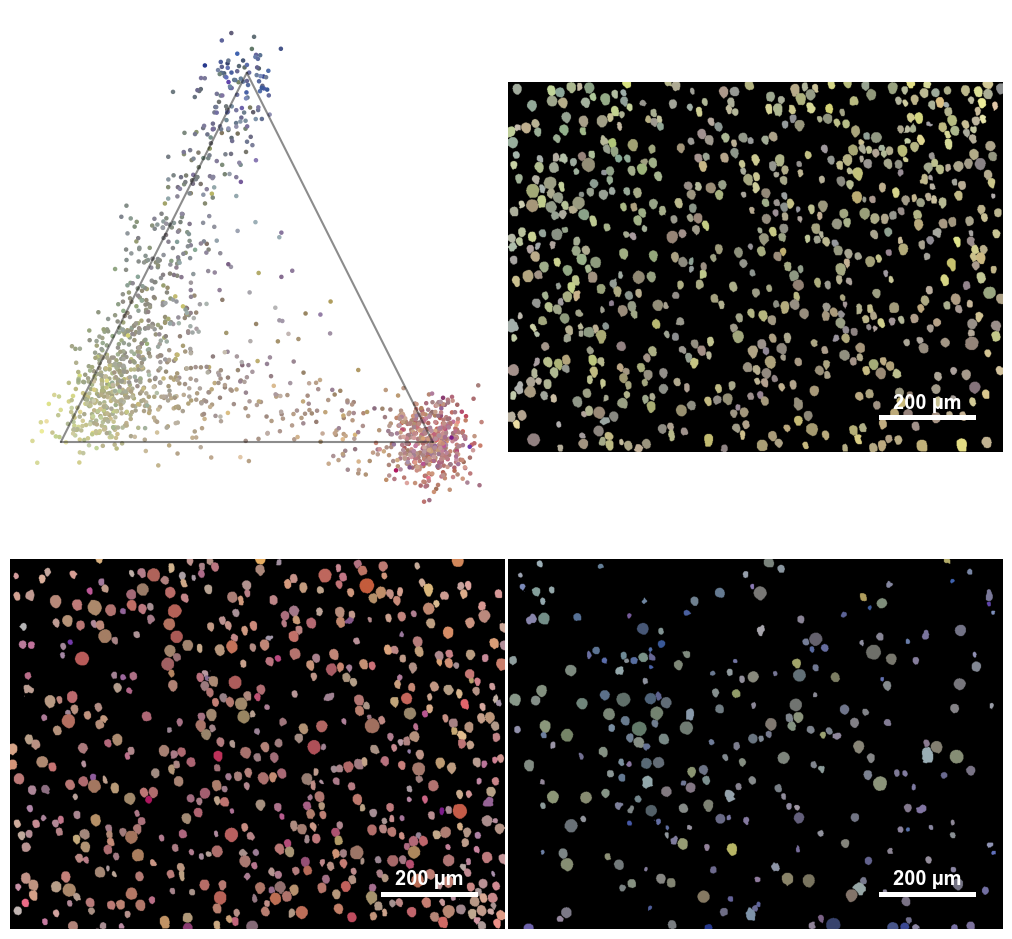

In [311]:
# Get probabilities for each point
probs = gm.predict_proba(colors)
assignment = probs.argmax(axis=-1)

def simplex_coords(probs):
    x = 0.5 * (2 * probs[:,1] + probs[:,2])
    y = (np.sqrt(3)/2) * probs[:,2]
    return x, y

# Get coordinates for each point
x_coords, y_coords = simplex_coords(probs) + np.random.normal(0, 0.05, size=(2, len(colors)))

# Create figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# Plot points colored by their RGB values
axes[0,0].scatter(x_coords, y_coords, color=colors, alpha=1.0, s=5)

axes[0,0].plot([0,1], [0,0], 'k-', alpha=0.5)
axes[0,0].plot([0,0.5], [0,np.sqrt(3)/2], 'k-', alpha=0.5)
axes[0,0].plot([1,0.5], [0,np.sqrt(3)/2], 'k-', alpha=0.5)

for i, ax in enumerate(axes.flatten()[1:]):
    sum_mask = make_visualisation(colors[assignment == i], masks_filtered[chosen_id][assignment == i])
    ax.imshow(np.minimum(sum_mask, 1.0))
    add_scalebar(ax, 200, '200 µm', color='white')
    ax.axis('off')

axes[0,0].axis('off')
fig.tight_layout(pad=0.2)
fig.savefig(f'out/simplex_{chosen_id}_{chosen_method}_{N_CLUSTERS}clusters.svg', bbox_inches='tight', transparent=True)